Autosaving every 60 seconds


# Predicting football player's rating using machine learning

## 0 - Load neccessary libraries

In [1]:
import sqlite3
import time
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 1 - Load datasets from google drive

In [4]:
# - Mount google drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# Create your connection.
database = sqlite3.connect('/content/drive/My Drive/Data/European_soccer_db/database.sqlite')

## 2 - Data prepocessing

In [6]:
# - get player_Attributes from the database
df = pd.read_sql_query("SELECT * FROM Player_Attributes", database)
df.head(5)

id  player_fifa_api_id  ...  gk_positioning gk_reflexes
0   1              218353  ...             8.0         8.0
1   2              218353  ...             8.0         8.0
2   3              218353  ...             8.0         8.0
3   4              218353  ...             7.0         7.0
4   5              218353  ...             7.0         7.0

[5 rows x 42 columns]

In [7]:
# Remove player_fifa_api_id, player_api_id, date and other columns with integer values
df_int = df.select_dtypes(include=['float'])
df_int.head()

overall_rating  potential  crossing  ...  gk_kicking  gk_positioning  gk_reflexes
0            67.0       71.0      49.0  ...        10.0             8.0          8.0
1            67.0       71.0      49.0  ...        10.0             8.0          8.0
2            62.0       66.0      49.0  ...        10.0             8.0          8.0
3            61.0       65.0      48.0  ...         9.0             7.0          7.0
4            61.0       65.0      48.0  ...         9.0             7.0          7.0

[5 rows x 35 columns]

In [8]:
# - check data shape
print("Dataset has {} entries and {} features".format(*df_int.shape))

Dataset has 183978 entries and 35 features


In [9]:
# Check if table contains missing values
def get_missing_values(data):
  if data.isnull().any().any():
    print('Data contain NaN in', data.isnull().sum(axis=0).max(),'rows')
  else:
    print('Data is without missing values')

In [10]:
get_missing_values(df_int)

Data contain NaN in 2713 rows


In [11]:
# - remove missing values
df_int = df_int.dropna()
print("Dataset now has {} entries and {} features".format(*df_int.shape))

Dataset now has 181265 entries and 35 features


## 3 - Predicting players rating from players attributes 

In this note book we are going to predict players rating using scores from multiple player's attributes.  To do this we are going to be using three different machine learning regressor :

1. Linear regressor
2. Decision Tree regressor
3. XGBRegressor


In [12]:
X = df_int[df_int.columns[1:]]
y = df_int[df_int.columns[0]]

In [13]:
X.head(3)

potential  crossing  finishing  ...  gk_kicking  gk_positioning  gk_reflexes
0       71.0      49.0       44.0  ...        10.0             8.0          8.0
1       71.0      49.0       44.0  ...        10.0             8.0          8.0
2       66.0      49.0       44.0  ...        10.0             8.0          8.0

[3 rows x 34 columns]

In [14]:
y.head(3)

0    67.0
1    67.0
2    62.0
Name: overall_rating, dtype: float64

In [15]:
# - rescale dataset
scaler=MinMaxScaler((-1,1))
x=scaler.fit_transform(X)

In [16]:
# - split datasets into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y.values, test_size=0.2)

### 3.1 - Using the default parameters of the models

In [17]:
lrg = LinearRegression()
dcr = DecisionTreeRegressor()
xgr = XGBRegressor(silent=True)

In [29]:
regressors = [lrg,dcr,xgr]
models = ['LinearRegression','DecisionTreeRegressor','XGBRegressor']

In [30]:
trained_model = []
for regressor,model,i in zip(regressors,models,np.arange(len(models))):
  t0 = time.time()
  regressor.fit(x_train,y_train)
  t1 = time.time()
  elapsed_time = int(t1 - t0)
  y_pred=regressor.predict(x_test)
  rmse = (mean_squared_error(y_test,y_pred.astype(int)))**0.5
  print("{}, {} rmse :{:1.2f} time taken :{}s".format(1+i,model,rmse,elapsed_time))
  trained_model.append(regressor)

1, LinearRegression rmse :2.86 time taken :0s
2, DecisionTreeRegressor rmse :1.31 time taken :3s
3, XGBRegressor rmse :1.83 time taken :19s


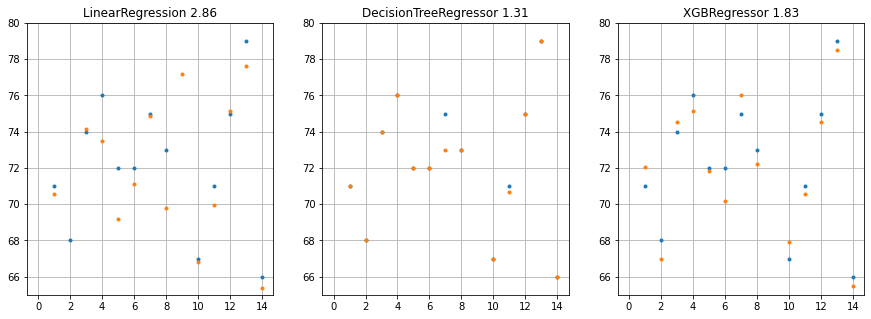

In [34]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
axs = ax.ravel()
for i,tmodel in enumerate(trained_model):
  y_predict = tmodel.predict(x_test)
  rmse = (mean_squared_error(y_test,y_predict.astype(int)))**0.5
  axs[i].plot(y_test[5:20],'.')
  axs[i].plot(y_predict[5:20],'.')
  axs[i].set_title(models[i] + " {:1.2f}".format(rmse))
  axs[i].set_ylim([65,80])
  axs[i].grid(True)

Decision Tree regressor has the best prediction when compared to the other models. This is evident in the RMSE score and in the visulization of the direct comparsion of the true and predicted player's rating.

### 3.2 - Could using the players attributes that are most correlated with rating as inputs features improve the model performace ?

In [41]:
# create a list containing Pearson's correlation between 'overall_rating' with each column in cols
correlations = [df_int['overall_rating'].corr(df_int[attribute]) 
                for attribute in df_int.columns[1:] ]

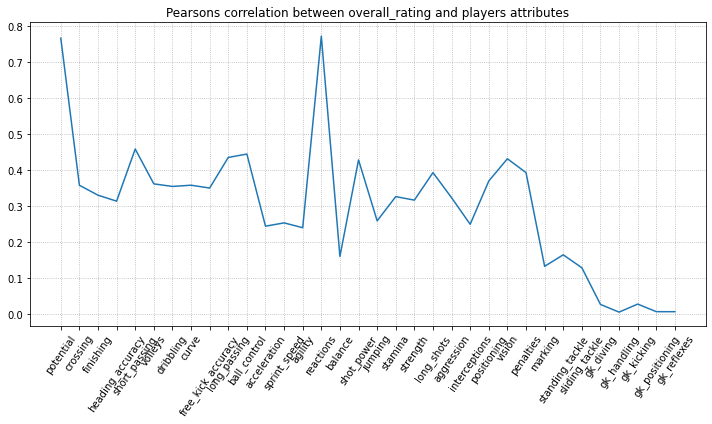

In [44]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
ax.plot(df_int.columns[1:],correlations)
ax.set_xticklabels(df_int.columns[1:], rotation=55)
plt.grid(True,ls='dotted')
plt.title('Pearsons correlation between overall_rating and players attributes')
plt.tight_layout()

In [45]:
# - take the features with correlation greater 0.3
correlated_attributes = df_int.columns[1:][np.array(correlations)>=0.3]
correlated_attributes

Index(['potential', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'reactions', 'shot_power', 'stamina',
       'strength', 'long_shots', 'aggression', 'positioning', 'vision',
       'penalties'],
      dtype='object')

In [46]:
len(correlated_attributes)

20

In [47]:
X_correlated = df_int[correlated_attributes]
# - rescale dataset
scaler=MinMaxScaler((-1,1))
x_corr=scaler.fit_transform(X_correlated)
x_train, x_test, y_train, y_test = train_test_split(x_corr, y.values, test_size=0.2)

In [48]:
trained_model = []
for regressor,model,i in zip(regressors,models,np.arange(len(models))):
  t0 = time.time()
  regressor.fit(x_train,y_train)
  t1 = time.time()
  elapsed_time = int(t1 - t0)
  y_pred=regressor.predict(x_test)
  rmse = (mean_squared_error(y_test,y_pred.astype(int)))**0.5
  print("{}, {} rmse :{:1.2f} time taken :{}s".format(1+i,model,rmse,elapsed_time))
  trained_model.append(regressor)

1, LinearRegression rmse :3.32 time taken :0s
2, DecisionTreeRegressor rmse :1.68 time taken :2s
3, XGBRegressor rmse :2.36 time taken :12s


All the tree model **performed worst** when we trained the model using only the most correlated players attributes compared to using all the players attributes in trainging the model.

### 3.3 - Tuning the model's hyperparameter 

In [20]:
#param_grids = [dict(max_depth=np.arange(1,20,2),min_samples_leaf=np.arange(1,6,2)),
               #dict(max_depth=np.arange(1,20,2),min_child_weight = np.arange(1,6,2),eta = [0.01, 0.1,1.0])]

In [25]:
training_data = x_train,y_train 
test_data = x_test,y_test
regressors = [dcr,xgr]
models = ['DecisionTreeRegressor','XGBRegressor']
param_grids = [dict(max_depth=np.arange(1,20,2)),
               dict(max_depth=np.arange(1,20,2))]
classifiers = [DecisionTreeRegressor()]

In [22]:
# - define function to run multiple model
def run_multiple_models(regressors,models,param_grids,training_data,test_data):  
    x_train,y_train = training_data
    x_test,y_test = test_data
    best_model = []
    for regressor, model, param_grid in zip(regressors, models, param_grids):
        grid = GridSearchCV(regressor, param_grid=param_grid, cv= 5, n_jobs=-1)
        grid.fit(x_train, y_train)

        rgs = grid.best_estimator_ 
        rgs.fit(x_train,y_train)
        best_model.append(grid)

        y_predict = rgs.predict(x_test)
        model_RMSE = "{:1.2f}".format((mean_squared_error(y_test,y_predict.astype(int)))**0.5)
        best_param = grid.best_params_
        print("MSE for {}: {} (best parameters {})".format(model,model_RMSE,best_param))
    return best_model